In [69]:
!pip install opencv-python
!pip install torchvision 
!pip install torchfile 

import cv2
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchfile
from torchvision import datasets, models, transforms
from torchvision.io import read_image
from matplotlib import pyplot as plt
import numpy as np
import torch.optim as optim

In [216]:
class VGG_16(nn.Module):
    """
    Main Class
    """

    def __init__(self):
        """
        Constructor
        """
        super(VGG_16, self).__init__()
        self.block_size = [2, 2, 3, 3, 3]
        self.conv_1_1 = nn.Conv2d(3, 64, 3, stride=1, padding=1)
        self.conv_1_2 = nn.Conv2d(64, 64, 3, stride=1, padding=1)
        self.conv_2_1 = nn.Conv2d(64, 128, 3, stride=1, padding=1)
        self.conv_2_2 = nn.Conv2d(128, 128, 3, stride=1, padding=1)
        self.conv_3_1 = nn.Conv2d(128, 256, 3, stride=1, padding=1)
        self.conv_3_2 = nn.Conv2d(256, 256, 3, stride=1, padding=1)
        self.conv_3_3 = nn.Conv2d(256, 256, 3, stride=1, padding=1)
        self.conv_4_1 = nn.Conv2d(256, 512, 3, stride=1, padding=1)
        self.conv_4_2 = nn.Conv2d(512, 512, 3, stride=1, padding=1)
        self.conv_4_3 = nn.Conv2d(512, 512, 3, stride=1, padding=1)
        self.conv_5_1 = nn.Conv2d(512, 512, 3, stride=1, padding=1)
        self.conv_5_2 = nn.Conv2d(512, 512, 3, stride=1, padding=1)
        self.conv_5_3 = nn.Conv2d(512, 512, 3, stride=1, padding=1)
        self.fc6 = nn.Linear(512 * 7 * 7, 4096)
        self.dropout6 = nn.Dropout(p=0.5)
        self.fc7 = nn.Linear(4096, 4096)
        self.dropout7 = nn.Dropout(p=0.5)
        self.fc8 = nn.Linear(4096, 2622)

    # path was "./../../VGG_FACE.t7"
    def load_weights(self, path="/mnt/cube/projects/xiaojing/VGG_FACE.t7"):
        """ Function to load luatorch weights
        Args:
            path: path for the luatorch weights
        """
        model = torchfile.load(path)
        counter = 1
        block = 1
        for i, layer in enumerate(model.modules):
            if hasattr(layer, "weight") and layer.weight is not None:
                if block <= 5:
                    self_layer = getattr(self, "conv_%d_%d" % (block, counter))
                    counter += 1
                    if counter > self.block_size[block - 1]:
                        counter = 1
                        block += 1
                    self_layer.weight.data[...] = torch.from_numpy(layer.weight).view_as(self_layer.weight)[...]
                    self_layer.bias.data[...] = torch.from_numpy(layer.bias).view_as(self_layer.bias)[...]
                else:
                    self_layer = getattr(self, "fc%d" % (block))
                    block += 1
                    self_layer.weight.data[...] = torch.from_numpy(layer.weight).view_as(self_layer.weight)[...]
                    self_layer.bias.data[...] = torch.from_numpy(layer.bias).view_as(self_layer.bias)[...]

    def forward(self, x):
        """ Pytorch forward
        Args:
            x: input image (224x224)
        Returns: class logits
        """
        x = F.relu(self.conv_1_1(x))
        x = F.relu(self.conv_1_2(x))
        x = F.max_pool2d(x, 2, 2)
        x = F.relu(self.conv_2_1(x))
        x = F.relu(self.conv_2_2(x))
        x = F.max_pool2d(x, 2, 2)
        x = F.relu(self.conv_3_1(x))
        x = F.relu(self.conv_3_2(x))
        x = F.relu(self.conv_3_3(x))
        x = F.max_pool2d(x, 2, 2)
        x = F.relu(self.conv_4_1(x))
        x = F.relu(self.conv_4_2(x))
        x = F.relu(self.conv_4_3(x))
        x = F.max_pool2d(x, 2, 2)
        x = F.relu(self.conv_5_1(x))
        x = F.relu(self.conv_5_2(x))
        x = F.relu(self.conv_5_3(x))
        x = F.max_pool2d(x, 2, 2)
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc6(x))
        x = self.dropout6(x)
        x = F.relu(self.fc7(x))
        x = self.dropout7(x)
        return self.fc8(x)

In [217]:
model = VGG_16()
model.load_weights()

In [219]:
num_classes = 10

num_ftrs = model.fc8.in_features
model.fc8 = nn.Linear(num_ftrs, num_classes)
input_size = 224

In [237]:
val_transform = transforms.Compose([
            # BGR2RGB(),
            transforms.ToPILImage(),
            transforms.Resize(256),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            transforms.Normalize([0.3873985 , 0.42637664, 0.53720075], [0.2046528 , 0.19909547, 0.19015081])
            ])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


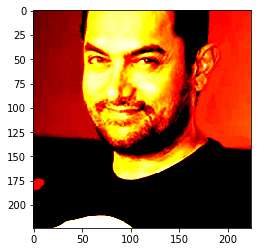

In [238]:
img = read_image('data/vgg_face_matconvnet/ak.jpg')
img = val_transform(img)
plt.imshow(img.permute(1, 2, 0))

img = img.unsqueeze(0)

In [239]:
outputs = model(img) * torch.FloatTensor([16] + [5]*9)

In [240]:
preds = F.softmax(outputs, -1)
values, indices = preds.max(-1)
indices

tensor([7])